# PHY 266 HW 6

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import glob
import astropy.units as u

from matplotlib.patches import Ellipse
from math import pi
from scipy import special
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM 

## Prb 1. ΛCDM and supernovae: first view of the likelihood surface.

### 1 a)

In [2]:
data = np.loadtxt('../data/union-supernova-catalog.txt')
z = data[:,0]
DM = data[:,1]*u.mag
sigma = data[:,2]
n = len(z)

In [3]:
num_H = 61    # number of points in the H axis of the grid
num_Om = 60    # number of points in the Omega_m axis of the grid

In [4]:
H_vals = np.linspace(60, 80, num_H)
Om_vals = np.linspace(0.0,1.0,num_Om)

In [5]:
log_L = np.zeros((num_H, num_Om))

In [6]:
for i, HO in enumerate(H_vals):
    for j, Om in enumerate(Om_vals):
        cosmo = FlatLambdaCDM(H0=HO * u.km / u.s / u.Mpc, Om0=Om)
        #print(cosmo)
        DM_model = cosmo.distmod(z)
        #print(DM_model[20:30])
        chi2 = np.sum(((DM - DM_model) / sigma).value**2)
        #print(0.5*chi2)
        log_L[i][j] = -0.5*chi2

In [7]:
X,Y = np.meshgrid(Om_vals, H_vals)

Text(0.5, 0, '$\\Omega_{m0}$')

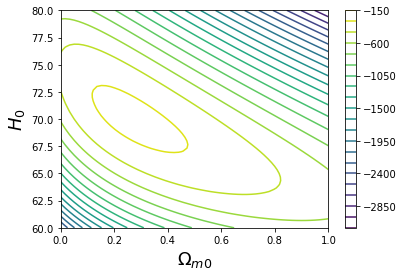

In [8]:
plt.contour(X,Y,log_L,20)
plt.colorbar()
plt.ylabel(r'$H_0$', fontdict={'fontsize':18})
plt.xlabel(r'$\Omega_{m0}$', fontdict={'fontsize':18})

### 1 b) Maximum likelihood values

In [9]:
ML_index =  np.unravel_index(log_L.argmax(), log_L.shape)

In [10]:
print('\n Maximum likelihood value for H0 : %f' %H_vals[ML_index[0]])
print('\n Maximum likelihood value for Omega_m : %f' %Om_vals[ML_index[1]])


 Maximum likelihood value for H0 : 70.000000

 Maximum likelihood value for Omega_m : 0.271186


## Prb 2. ΛCDM and supernovae: grid-based confidence intervals.

### 2 a) Marginal likelihood

In [11]:
num_H1 = 101    # number of points in the H axis of the grid
num_Om1 = 100    # number of points in the Omega_m axis of the grid

H_vals1 = np.linspace(60, 80, num_H1)
Om_vals1 = np.linspace(0.0,1.0,num_Om1)

log_L1 = np.zeros((num_H1, num_Om1))

for i, HO in enumerate(H_vals1):
    for j, Om in enumerate(Om_vals1):
        cosmo = FlatLambdaCDM(H0=HO * u.km / u.s / u.Mpc, Om0=Om)
        #print(cosmo)
        DM_model = cosmo.distmod(z)
        #print(DM_model[20:30])
        chi2 = np.sum(((DM - DM_model) / sigma).value**2)
        #print(0.5*chi2)
        log_L1[i][j] = -0.5*chi2

In [12]:
L_for_Om = log_L1.sum(axis=0)  # marginalized log likelihood for Omega_m
L_for_H = log_L1.sum(axis=1)

Text(0, 0.5, '$ln\\mathcal{L}$')

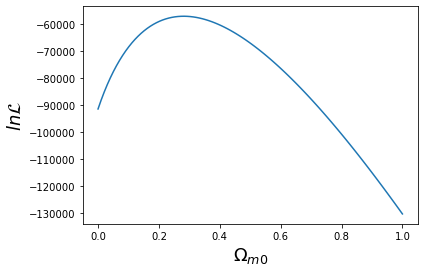

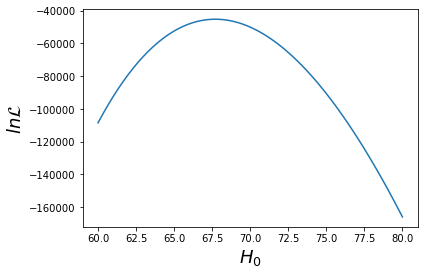

In [13]:
plt.plot(Om_vals1, L_for_Om)
plt.xlabel(r'$\Omega_{m0}$', fontdict={'fontsize':18})
plt.ylabel(r'$ln\mathcal{L}$', fontdict={'fontsize':18})
plt.figure()
plt.plot(H_vals1, L_for_H)
plt.xlabel(r'$H_0$', fontdict={'fontsize':18})
plt.ylabel(r'$ln\mathcal{L}$', fontdict={'fontsize':18})

### 2 b) HPDCI

In [14]:
norm =log_L1.flatten().sum()

Text(0, 0.5, '$ln\\mathcal{L}$')

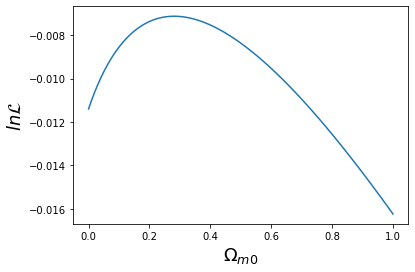

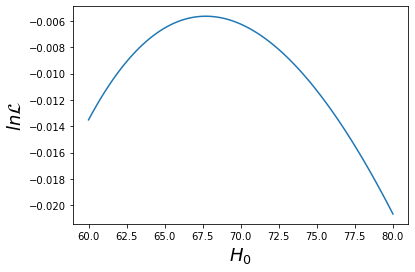

In [15]:
plt.plot(Om_vals1, -L_for_Om/norm)
plt.xlabel(r'$\Omega_{m0}$', fontdict={'fontsize':18})
plt.ylabel(r'$ln\mathcal{L}$', fontdict={'fontsize':18})
plt.figure()
plt.plot(H_vals1, -L_for_H/norm)
plt.xlabel(r'$H_0$', fontdict={'fontsize':18})
plt.ylabel(r'$ln\mathcal{L}$', fontdict={'fontsize':18})

In [16]:
def cal_HPDCI(likelihood, parm, interval):
    """
    Calculates highest probability density confidence
    interval given a 1D likelihood array, corresponding
    parameter array and desired interval.
    """
    max_ld_val = np.max(likelihood)
    percent = 0.0
    border = max_ld_val
    
    while percent < interval:
        border += -0.0001
        p = likelihood > border
        #print(p)
        percent = sum(1*p)/len(likelihood)
        #print(border)
        #print(percent)
        
        if percent >= interval :
            index = np.transpose(np.where(p==True))
            low_ind = index[0]
            high_ind = index[-1]
            parm_low = parm[low_ind]
            parm_high = parm[high_ind]
            
            #print(border)
            #print(percent)
            #print(index)
            #print(p)
            #print(low_ind)
            #print(high_ind)
            #print(parm_low)
            #print(parm_high)
            break
            
    return np.array([parm_low, parm_high])

In [17]:
interval_Om =  cal_HPDCI(-L_for_Om/norm, Om_vals1, 0.997)

print('\n 99.7%% HPDCI for Omega_m : %f - %f' %(interval_Om[0], interval_Om[1]))


 99.7% HPDCI for Omega_m : 0.000000 - 1.000000


In [18]:
interval_HO=  cal_HPDCI(-L_for_H/norm, H_vals1, 0.997)
print('\n 99.7%% HPDCI for HO : %f - %f' %(interval_HO[0], interval_HO[1]))


 99.7% HPDCI for HO : 60.000000 - 80.000000


## Prb 3. Confidence intervals: bootstrapping.

### 3 a) CI using bootstrap resampling

###  We can perform bootstrap resampling on our union supernovae catalog and obtain different realizations of the catalog. Then we can find out the best fit values of $H_0$ and $\Omega_m$ for each realization of the catalog. From these distributions of $H_0$ and $\Omega_m$ we can find out our desired individual interval for those parameters.

## 3 b)

### We can significantly decrease the time to search for best fit parameters for each resampling realization by working in a coarser grid at first. If our model space is a grid of 400*400 then we need to explore $400^2$ points. However we can first explore every 10 or 5 points in the grid and store the results. By exploring every 5 points in the grid we will effectively explore a 80*80 grid of model space. We can then check which points in the grid have the chance to be in the neighbourhood of the maximum likelihood. We can have a set of those points and next only explore those grid points in the neighbourhood surrounding these first set of points. In this way we can find the best fit parameters to our resampled realization more quickly. It would be better if we first check whether this method really yields the maximum likelihood parameters. To do this we will explore 400*400 grid for few realizations and cross validate the result obtained here and using our mentioned algorithm. 